In [1]:
from PIL import Image
import numpy as np
import utils as ut

In [2]:
import sys
import os
from PIL import Image

notebook_dir = os.path.dirname(os.path.abspath("__file__"))

test_images_path = os.path.abspath(os.path.join(notebook_dir, '../../../test_images'))



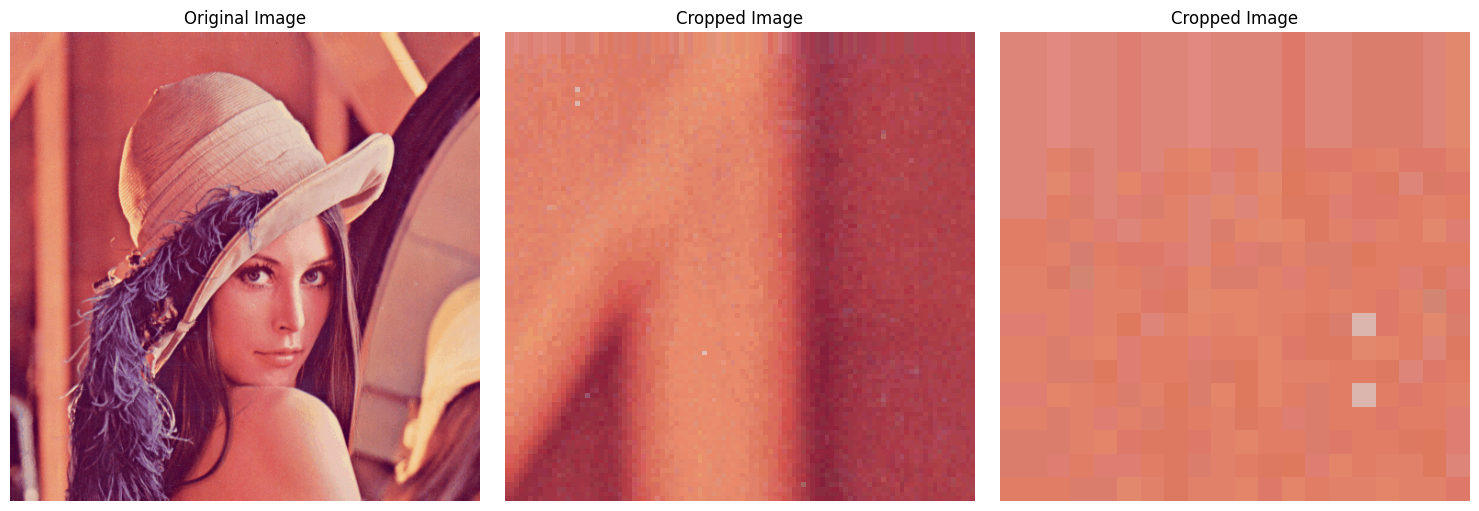

In [3]:
image_path = os.path.join(test_images_path, 'lenna.bmp')
image = Image.open(image_path)
ut.image_plotter([image, image.crop((0, 0, 100, 100)), image.crop((0,0,20,20))], ['Original Image', 'Cropped Image', 'Cropped Image'])



In [4]:
def mosaic_filter(image):

    red_bayer_pattern = np.array([
        [1, 0],
        [0, 0]
    ])

    green_bayer_pattern = np.array([
        [0, 1],
        [1, 0]
    ])

    blue_bayer_pattern = np.array([
        [0, 0],
        [0, 1]
    ])


    red_channel = np.array(image)[:, :, 0]
    green_channel = np.array(image)[:, :, 1]
    blue_channel = np.array(image)[:, :, 2]


    def apply_bayer_pattern(channel, pattern):
        row_repeat = False
        col_repeat = False

    
        if channel.shape[0] %2 != 0:
            #repeat the last row
            row_repeat = True
            channel = np.vstack((channel, channel[-1]))
        if channel.shape[1] %2 != 0:
            #repeat the last column
            col_repeat = True
            channel = np.hstack((channel, channel[:, -1].reshape(-1, 1)))
    
        for i in range(0, channel.shape[0], 2):
            for j in range(0, channel.shape[1], 2):
                channel[i:i+2, j:j+2] = channel[i:i+2, j:j+2] * pattern


        if row_repeat:
            channel = channel[:-1]
        if col_repeat:
            channel = channel[:, :-1]
        return channel
        
    red_channel = apply_bayer_pattern(red_channel, red_bayer_pattern)
    green_channel = apply_bayer_pattern(green_channel, green_bayer_pattern)
    blue_channel = apply_bayer_pattern(blue_channel, blue_bayer_pattern)


    image = np.stack((red_channel, green_channel, blue_channel), axis=-1)

    image = Image.fromarray(image.astype(np.uint8))
    return image



In [5]:
def demosaic_filter(image):
    r_channel = np.array(image)[:, :, 0].astype(np.uint32)
    g_channel = np.array(image)[:, :, 1].astype(np.uint32)
    b_channel = np.array(image)[:, :, 2].astype(np.uint32)

    def apply_demosaic_on_r_channel(channel):
        
        # pad the corners if the image is not even
        if row_padded := channel.shape[0] % 2 == 0:
            channel = np.vstack((channel, channel[-1]))
        if col_padded := channel.shape[1] % 2 == 0:
            channel = np.hstack((channel, channel[:, [-1]]))
        
        # interpolate the missing red values in horizontal direction
        start_x, start_y = 1,0
        for y in range(start_y, channel.shape[0], 2):
            for x in range(start_x, channel.shape[1], 2):
                channel[y,x] = (channel[y, x-1] + channel[y, x+1]) // 2


        # interpolate the missing red values in vertical direction
        start_x, start_y = 0,1 
        for x in range(start_x, channel.shape[1], 2):
            for y in range(start_y, channel.shape[0], 2):
                channel[y,x] = (channel[y-1, x] + channel[y+1, x]) // 2
        

        start_x, start_y = 1,1
        for y in range(start_y, channel.shape[0], 2):
            for x in range(start_x, channel.shape[1], 2):
                channel[y,x] = (channel[y -1 , x-1] + channel[y +1 , x+1] + channel[y-1, x + 1 ] + channel[y+1, x + 1]) // 4


        if row_padded:
            channel = channel[:-1]
        if col_padded:
            channel = channel[:, :-1]
        
        return channel
    
    def apply_demosaic_on_b_channel(channel):
        channel = np.vstack((channel[1], channel))
        channel = np.hstack((channel[:,[1]], channel))
        apply_demosaic_on_r_channel(channel)

        return channel[1:, 1:]
    
    def apply_demosaic_on_g_channel(channel):

        # pad all corners
        channel = np.vstack((channel[1], channel))
        channel = np.hstack((channel[:,[1]], channel))
        
        if row_padded := channel.shape[0] % 2 == 0:
            channel = np.vstack((channel, channel[-1]))
        if col_padded := channel.shape[1] % 2 == 0:
            channel = np.hstack((channel, channel[:, [-1]]))

        start_x, start_y = 1,1
        for y in range(start_y, channel.shape[0], 2):
            for x in range(start_x, channel.shape[1], 2):
                channel[y,x] = (channel[y, x-1] + channel[y, x+1] + channel[y-1, x] + channel[y+1, x]) // 4
                
        if row_padded:
            channel = channel[:-1]
        if col_padded:
            channel = channel[:, :-1]

        if row_padded:= channel.shape[0] % 2 != 0:
            channel = np.vstack((channel, channel[-1]))
        if col_padded:= channel.shape[1] % 2 != 0:
            channel = np.hstack((channel, channel[:, [-1]]))


        start_x, start_y = 2,2
        for y in range(start_y, channel.shape[0] , 2):
            for x in range(start_x, channel.shape[1], 2):
                channel[y,x] = (channel[y, x-1] + channel[y, x+1] + channel[y-1, x] + channel[y+1, x]) // 4
        if row_padded:
            channel = channel[:-1]
        if col_padded:
            channel = channel[:, :-1]
        
        return channel[1:, 1:]
    
    r_channel = apply_demosaic_on_r_channel(r_channel).astype(np.uint8)
    b_channel = apply_demosaic_on_b_channel(b_channel).astype(np.uint8)
    g_channel = apply_demosaic_on_g_channel(g_channel).astype(np.uint8)

    image = np.stack((r_channel, g_channel, b_channel), axis=-1)

    image = Image.fromarray(image.astype(np.uint8))
    return image


In [6]:
def meanAbsoluteError(np_array1, np_array2):
    total_error = 0
    arr1 = np_array1.astype(np.float32)
    arr2 = np_array2.astype(np.float32)

    for i in range(arr1.shape[0]):
        for j in range(arr1.shape[1]):
            total_error  += abs(arr1[i][j] - arr2[i][j])

    return total_error / (arr1.shape[0] * arr2.shape[1])

def meanSquaredError(np_array1, np_array2):
    total_error = 0
    arr1 = np_array1.astype(np.float32)
    arr2 = np_array2.astype(np.float32)

    for i in range(arr1.shape[0]):
        for j in range(arr1.shape[1]):
            total_error  += (arr1[i][j] - arr2[i][j]) ** 2

    return total_error / (arr1.shape[0] * arr1.shape[1])


def peakSignalToNoiseRatio(np_array1, np_array2):
    max_val = 255
    mse = meanAbsoluteError(np_array1, np_array2)
    return 20 * np.log10(max_val / mse)

    


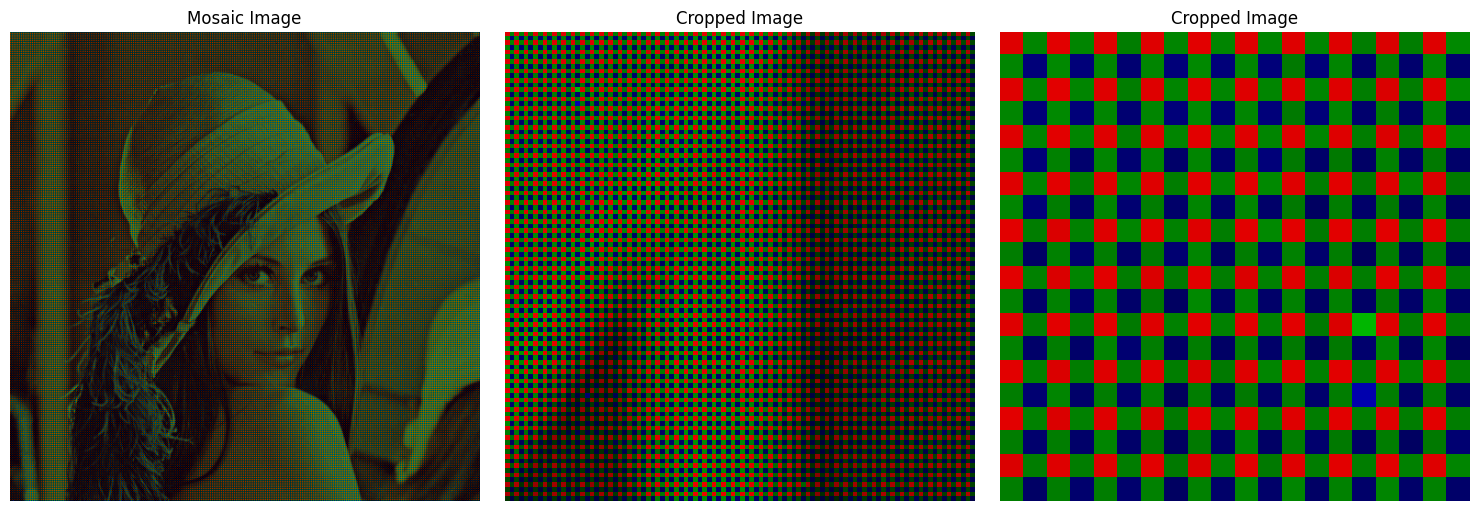

In [7]:
mosaic_image = mosaic_filter(image)
ut.image_plotter([mosaic_image, mosaic_image.crop((0, 0, 100, 100)), mosaic_image.crop((0,0,20,20))], ['Mosaic Image', 'Cropped Image', 'Cropped Image'])

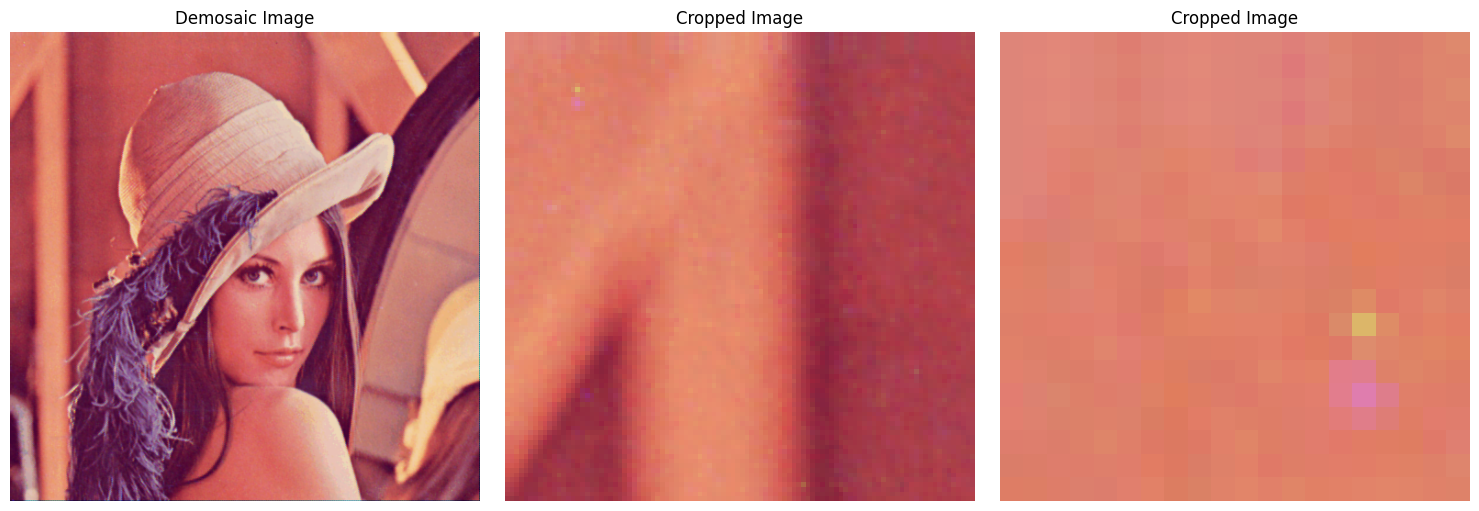

In [8]:
demosaic_image = demosaic_filter(mosaic_image)
ut.image_plotter([demosaic_image, demosaic_image.crop((0, 0, 100, 100)), demosaic_image.crop((0,0,20,20))], ['Demosaic Image', 'Cropped Image', 'Cropped Image'])

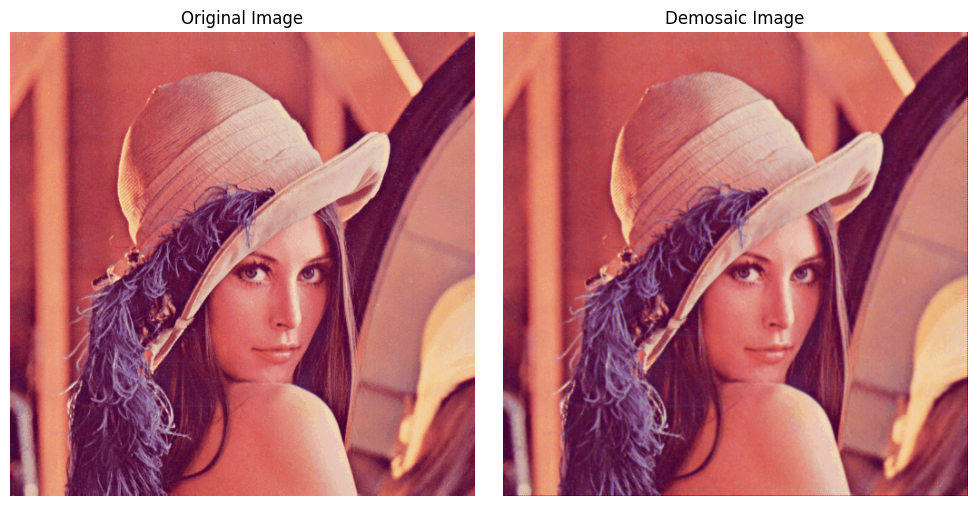

In [9]:
ut.image_plotter([image, demosaic_image], ['Original Image', 'Demosaic Image'])

In [10]:


red_channel_mae = meanAbsoluteError(np.array(image)[:, :, 0], np.array(demosaic_image)[:, :, 0])
green_channel_mae = meanAbsoluteError(np.array(image)[:, :, 1], np.array(demosaic_image)[:, :, 1])
blue_channel_mae = meanAbsoluteError(np.array(image)[:, :, 2], np.array(demosaic_image)[:, :, 2])

red_channel_psnr = peakSignalToNoiseRatio(np.array(image)[:, :, 0], np.array(demosaic_image)[:, :, 0])
green_channel_psnr = peakSignalToNoiseRatio(np.array(image)[:, :, 1], np.array(demosaic_image)[:, :, 1])
blue_channel_psnr = peakSignalToNoiseRatio(np.array(image)[:, :, 2], np.array(demosaic_image)[:, :, 2])

print(f"Mean Absolute Error for Red Channel: {red_channel_mae}")
print(f"Mean Absolute Error for Green Channel: {green_channel_mae}")
print(f"Mean Absolute Error for Blue Channel: {blue_channel_mae}")

print(f"Peak Signal to Noise Ratio for Red Channel: {red_channel_psnr}")
print(f"Peak Signal to Noise Ratio for Green Channel: {green_channel_psnr}")
print(f"Peak Signal to Noise Ratio for Blue Channel: {blue_channel_psnr}")


Mean Absolute Error for Red Channel: 3.710735321044922
Mean Absolute Error for Green Channel: 2.4059677124023438
Mean Absolute Error for Blue Channel: 4.3910369873046875
Peak Signal to Noise Ratio for Red Channel: 36.74160385131836
Peak Signal to Noise Ratio for Green Channel: 40.505008697509766
Peak Signal to Noise Ratio for Blue Channel: 35.27946090698242
